In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, 
                              BaggingRegressor, ExtraTreesRegressor)
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor

In [2]:
%matplotlib inline
sns.set_style(style='whitegrid')
plt.rcParams['figure.figsize'] = (20, 10)
pd.options.display.max_columns = None

In [3]:
train_set = (pd.read_csv('train.csv').drop('Unnamed: 0', axis=1))
test_set = pd.read_csv('test.csv')
answer_set = pd.DataFrame()

In [4]:
features = test_set.columns
train = train_set[features].copy()
test = test_set.copy()

In [5]:
train['TARGET'] = train_set['NU_NOTA_MT'].copy()

In [6]:
train.drop(['NU_INSCRICAO', 'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT'], axis=1, inplace=True)
test.drop(['NU_INSCRICAO', 'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT'], axis=1, inplace=True)

In [7]:
cat_features = train.dtypes[train.dtypes == 'object'].index
num_features = train.dtypes[train.dtypes != 'object'].index

In [8]:
corr = train[num_features].corr()

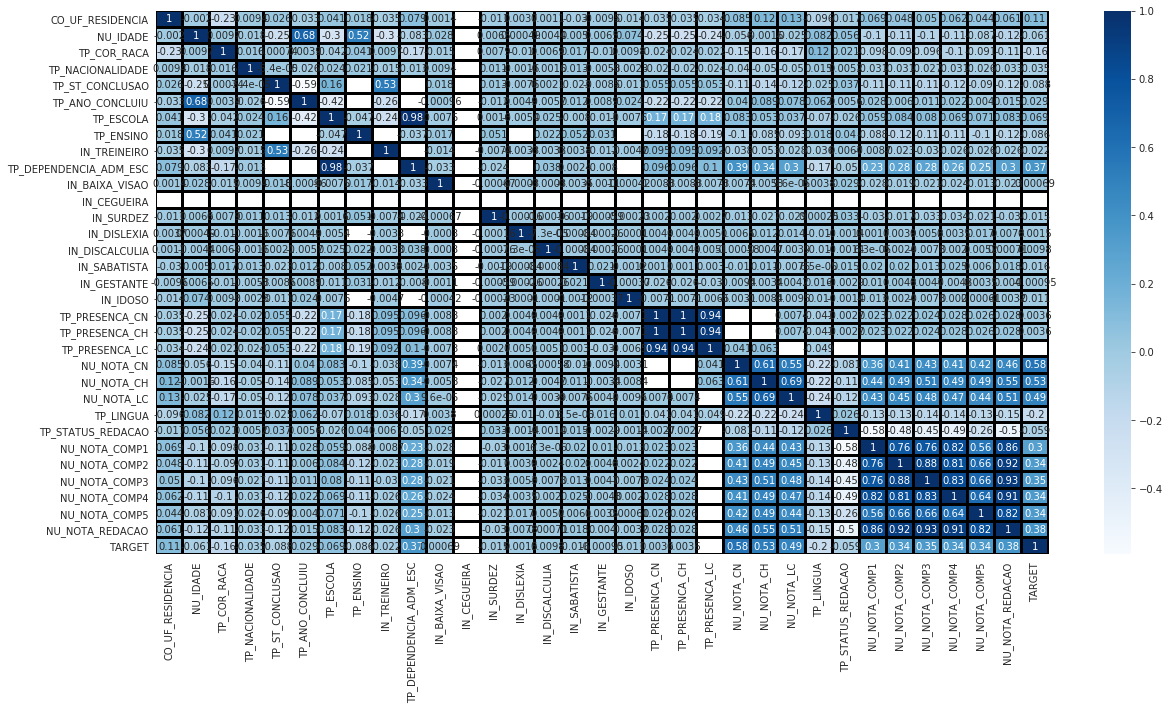

In [9]:
sns.heatmap(corr, annot=True, linewidths=2, linecolor='black', cmap='Blues')
plt.show()

In [10]:
num_features_fit = ['CO_UF_RESIDENCIA', 'TP_DEPENDENCIA_ADM_ESC', 'NU_NOTA_CN', 
                'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_COMP1', 
                'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 
                'NU_NOTA_COMP5', 'NU_NOTA_REDACAO']

target = train['TARGET'].copy()

num_features_train_set = train[num_features_fit].copy()
num_features_test_set = test[num_features_fit].copy()

cat_features_train_set = train[cat_features].copy()
cat_features_test_set = test[cat_features].copy()

In [11]:
target.fillna(0, inplace=True)

In [12]:
num_features_train_set.fillna(-1, inplace=True)
num_features_test_set.fillna(-1, inplace=True)

cat_features_train_set.fillna('Missing', inplace=True)
cat_features_test_set.fillna('Missing', inplace=True)

Normalizando as variáveis numéricas de treino e teste

In [13]:
for col in num_features_train_set.columns:
    scaler = MinMaxScaler()
    num_features_train_set[col] = scaler.fit_transform(num_features_train_set[col].values.reshape(-1, 1))

In [14]:
for col in num_features_test_set.columns:
    scaler = MinMaxScaler()
    num_features_test_set[col] = scaler.fit_transform(num_features_test_set[col].values.reshape(-1, 1))

Tranformando as variáveis categóricas de treino e teste

In [15]:
for col in cat_features_train_set.columns:
    onehot = OneHotEncoder(sparse=False, handle_unknown='ignore')
    cat_features_train_set[col] = onehot.fit_transform(cat_features_train_set[col].values.reshape(-1, 1))

In [16]:
for col in cat_features_test_set.columns:
    onehot = OneHotEncoder(sparse=False, handle_unknown='ignore')
    cat_features_test_set[col] = onehot.fit_transform(cat_features_test_set[col].values.reshape(-1, 1))

In [17]:
X_train = pd.concat([num_features_train_set, cat_features_train_set], axis=1)
X_test = pd.concat([num_features_test_set, cat_features_test_set], axis=1)
y = np.log1p(target)

### Validação

In [21]:
def rmsle_log_y(estimator, X, y):
    p = estimator.predict(X)
    return np.sqrt(mean_squared_error(y, p))

In [22]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

#### Árvores de decisão

In [157]:
dtree = DecisionTreeRegressor(max_depth=2)
error = cross_val_score(dtree, X_train, y, cv=kfold, scoring=rmsle_log_y).mean()
error

0.16521240556714575

In [158]:
etree = ExtraTreeRegressor(max_depth=2)
error = cross_val_score(etree, X_train, y, cv=kfold, scoring=rmsle_log_y).mean()
error

0.18523481713586848

Floresta aleatória

In [159]:
rforest = RandomForestRegressor(n_estimators=1000, random_state=0)
error = cross_val_score(rforest, X_train, y, cv=kfold, scoring=rmsle_log_y).mean()
error

0.1556097607850649

In [160]:
gbregressor = GradientBoostingRegressor(n_estimators=1000, random_state=0, learning_rate=0.1)
error = cross_val_score(gbregressor, X_train, y, cv=kfold, scoring=rmsle_log_y).mean()
error

0.1572079901030132

In [162]:
bregressor = BaggingRegressor(n_estimators=1000, random_state=0)
error = cross_val_score(bregressor, X_train, y, cv=kfold, scoring=rmsle_log_y).mean()
error

0.15552914088104255

In [163]:
etres = ExtraTreesRegressor(n_estimators=1000, random_state=0)
error = cross_val_score(etres, X_train, y, cv=kfold, scoring=rmsle_log_y).mean()
error

0.1575524661710305

### Turning the model

Random Forest

In [ ]:
random_grid = {
        'bootstrap': [True, False],
        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        'max_features': ['auto', 'log2'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}

In [165]:
rf = RandomForestRegressor(warm_start=True)
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, 
                               n_iter=100, cv=3, verbose=2, 
                               random_state=42, n_jobs=-1)
rf_random.fit(X_train, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 66.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 139.6min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [166]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 200}

In [24]:
params = {'bootstrap': True,
     'max_depth': 10,
     'max_features': 'auto',
     'min_samples_leaf': 4,
     'min_samples_split': 5,
     'n_estimators': 200}
etres = ExtraTreesRegressor(**params)
etres.fit(X_train, y)

ExtraTreesRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                    max_depth=10, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=4,
                    min_samples_split=5, min_weight_fraction_leaf=0.0,
                    n_estimators=200, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

In [25]:
y_pred_rf = etres.predict(X_test)

In [26]:
answer_set['NU_INSCRICAO'] = test_set['NU_INSCRICAO'].copy()

In [30]:
answer_set['NU_NOTA_MT'] = np.round(np.expm1(y_pred_rf), 2)

In [31]:
answer_set.to_csv('answer.csv', index=False, header=True)